# AlexNet

Commands for colab :

```
from google.colab import files
files.upload()
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp 'kaggle.json' ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d ifigotin/imagenetmini-1000
!unzip /content/imagenetmini-1000.zip
```

In [105]:
import numpy as np
import matplotlib.pyplot as plt
import math
from IPython import display

import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils import data
from torch.utils.data import Dataset
from torchvision import transforms

import multiprocessing
import random
import os
import time
import cv2

np.random.seed(seed=1)

In [106]:
BASE_DIR = os.path.join('.')

image_path = os.path.join(BASE_DIR,'imagenet-mini')
labels_path = os.path.join(BASE_DIR, 'words.txt')

class ImageNetMiniDataset(Dataset):
    def __init__(self, annotations_file, img_dir, resize=(224,224), train=True, transform=None, target_transform=None):
        self.img_labels = self.read_labels(annotations_file)
        self.img_dir_paths = self.read_image_paths(img_dir,train)
        self.train = train
        self.transform = transform
        self.target_transform = target_transform
        self.resize_dim = resize

    def read_labels(self,path):
        labels_dict = dict()
        label_value = 0
        with open(path, 'r') as f:
            while True:
                label = f.readline()
                if len(label) == 0:
                    break
                label = label.split('\t')
                labels_dict[label[0]] = label[1]
                label_value += 1
        return labels_dict

    def read_image_paths(self,img_dir,train):
        sub_path = 'train' if train else 'val'
        result = []
        path = os.path.join(img_dir, sub_path)
        for current in os.listdir(path):
            current_path = os.path.join(path,current)
            for current_file in os.listdir(current_path):
                result.append((os.path.join(current_path,current_file),current))
        return result

    def __len__(self):
        return len(self.img_dir_paths)

    def __getitem__(self, idx):
        img_path, label = self.img_dir_paths[idx]
        image = cv2.resize(cv2.imread(img_path), self.resize_dim, interpolation=cv2.INTER_AREA)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

transform = transforms.Compose(
    [
        transforms.ToTensor()
    ]
)


class LazyDataLoader:

    def __init__(self, dataset, batch_size=10, shuffle=False, num_workers=0):
        self.dataset = dataset
        self.batch_size = batch_size
        # self.shuffle = shuffle
        self.num_workers = num_workers
        self.total_batches = len(dataset)//batch_size + (0 if len(dataset)%batch_size == 0 else 1)
        self.extras = 0 if len(dataset)%batch_size == 0 else len(dataset)%batch_size
    
    def __len__(self):
        return self.total_batches
    
    def __iter__(self):
        self.label_map = dict()
        counter = np.arange(self.total_batches*self.batch_size)
        np.random.shuffle(counter)
        self.counter = counter.reshape((self.total_batches,self.batch_size,-1))
        print('batch-shape : ',self.counter.shape)
        self.current_batch = 0
        return self
    
    def fetch_data(self, index):
      image,label = self.dataset[index[0]]
      return (image,self.getLabelFromMap(label))
    
    def __next__(self):
        if self.current_batch >= self.counter.shape[0]:
            raise StopIteration
        if self.num_workers != 0:
            thread_pool = multiprocessing.Pool(self.num_workers)
            tensors_per_batch = thread_pool.map(self.fetch_data, [indexes for indexes in self.counter[self.current_batch] if indexes < len(self.dataset)])
            x_all = []
            y_all = []
            for values in tensors_per_batch:
                x_all.append(values[0])
                y_all.append(values[1])
            self.current_batch += 1
            return torch.stack(x_all),torch.LongTensor(y_all)
        else:
            # for current_batch in range(self.total_batches):
            x_all = []
            y_all = []
            for i in self.counter[self.current_batch]:
                if i >= len(self.dataset):
                    continue
                x,y = self.fetch_data(i)
                x_all.append(x)
                y_all.append(y)
            self.current_batch += 1
            # print(self.current_batch)
            return torch.stack(x_all),torch.LongTensor(y_all)
        raise StopIteration

    def getLabelFromMap(self, y):
        c_label = None
        if y in self.label_map:
            c_label = self.label_map[y]
        else:
            c_label = len(self.label_map)
            self.label_map[y] = c_label
        return c_label

In [108]:
net = torch.nn.Sequential(
    nn.Conv2d(3, 96, kernel_size=11, stride=4),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(96, 256, kernel_size=5, padding=2),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Conv2d(256, 384, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(384, 384, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.Conv2d(384, 256, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=3, stride=2),
    nn.Flatten(),
    nn.Linear(6400, 4096),
    nn.ReLU(),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Linear(4096, 1000),
)

X = torch.rand(size=(10, 3, 224, 224), dtype=torch.float32)
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, "output shape: \t", X.shape)

Conv2d output shape: 	 torch.Size([10, 96, 54, 54])
ReLU output shape: 	 torch.Size([10, 96, 54, 54])
MaxPool2d output shape: 	 torch.Size([10, 96, 26, 26])
Conv2d output shape: 	 torch.Size([10, 256, 26, 26])
ReLU output shape: 	 torch.Size([10, 256, 26, 26])
MaxPool2d output shape: 	 torch.Size([10, 256, 12, 12])
Conv2d output shape: 	 torch.Size([10, 384, 12, 12])
ReLU output shape: 	 torch.Size([10, 384, 12, 12])
Conv2d output shape: 	 torch.Size([10, 384, 12, 12])
ReLU output shape: 	 torch.Size([10, 384, 12, 12])
Conv2d output shape: 	 torch.Size([10, 256, 12, 12])
ReLU output shape: 	 torch.Size([10, 256, 12, 12])
MaxPool2d output shape: 	 torch.Size([10, 256, 5, 5])
Flatten output shape: 	 torch.Size([10, 6400])
Linear output shape: 	 torch.Size([10, 4096])
ReLU output shape: 	 torch.Size([10, 4096])
Linear output shape: 	 torch.Size([10, 4096])
ReLU output shape: 	 torch.Size([10, 4096])
Linear output shape: 	 torch.Size([10, 1000])


In [109]:
class Animator:
    """For plotting data in animation."""

    def __init__(
        self,
        xlabel=None,
        ylabel=None,
        legend=None,
        xlim=None,
        ylim=None,
        xscale="linear",
        yscale="linear",
        fmts=("-", "m--", "g-.", "r:"),
        nrows=1,
        ncols=1,
        figsize=(3.5, 2.5),
    ):
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        display.set_matplotlib_formats("svg")
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [
                self.axes,
            ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: set_axes(self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)


class Timer:
    """Record multiple running times."""

    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """Start the timer."""
        self.tik = time.time()

    def stop(self):
        """Stop the timer and record the time in a list."""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """Return the average time."""
        return sum(self.times) / len(self.times)

    def sum(self):
        """Return the sum of time."""
        return sum(self.times)

    def cumsum(self):
        """Return the accumulated time."""
        return np.array(self.times).cumsum().tolist()


class Accumulator:
    """For accumulating sums over `n` variables."""

    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [110]:
def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

In [111]:
def try_gpu(i=0):
    """Return gpu(i) if exists, otherwise return cpu()."""
    if torch.cuda.device_count() >= i + 1:
        return torch.device(f"cuda:{i}")
    return torch.device("cpu")

In [112]:
# We compute classification accuracy on the current batch
# and add this metric to the accumulator, for plotting purposes


def evaluate_accuracy_gpu(net, data_iter, device=None):
    """Compute the accuracy for a model on a dataset using a GPU."""
    if isinstance(net, torch.nn.Module):
        net.eval()  # Set the model to evaluation mode
        if not device:
            device = next(iter(net.parameters())).device
    # No. of correct predictions, no. of predictions
    metric = Accumulator(2)
    for X, y in data_iter:
        X = X.to(device)
        y = y.to(device)
        metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]


def accuracy(y_hat, y):
    """Compute the number of correct predictions."""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = torch.argmax(y_hat, axis=1)
    cmp_ = y_hat.type(y.dtype) == y
    return float(cmp_.type(y.dtype).sum())

In [113]:
def train(net, train_iter, test_iter, num_epochs, lr, device):
    def init_weights(m):
        if type(m) == nn.Linear or type(m) == nn.Conv2d:
            nn.init.xavier_uniform_(m.weight)

    net.apply(init_weights)
    print("training on", device)
    net.to(device)
    optimizer = torch.optim.SGD(net.parameters(), lr=lr)
    loss = nn.CrossEntropyLoss()
    animator = Animator(xlabel="epoch", xlim=[1, num_epochs], legend=["train loss", "train acc", "test acc"])
    timer, num_batches = Timer(), len(train_iter)
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples
        metric = Accumulator(3)
        net.train()
        for i, (X, y) in enumerate(train_iter):
            # print(X.shape,y.shape)
            timer.start()
            optimizer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            # print(y_hat.shape)
            # print(y.shape)
            l = loss(y_hat, y)
            l.backward()
            optimizer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], accuracy(y_hat, y), X.shape[0])
            timer.stop()
            train_l = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            # if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
            # animator.add(epoch + (i + 1) / num_batches, (train_l, train_acc, None))
            print(epoch + (i + 1)/ num_batches , (train_l, train_acc, None))
        test_acc = evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
    print(f"loss {train_l:.3f}, train acc {train_acc:.3f}, " f"test acc {test_acc:.3f}")
    print(f"{metric[2] * num_epochs / timer.sum():.1f} examples/sec " f"on {str(device)}")

training on cpu
batch-shape :  (35, 1000, 1)


/var/folders/75/_0h54l8n6ys6k7klg1v8zggh0000gn/T/ipykernel_2304/1105713519.py:21: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats("svg")
Process SpawnPoolWorker-2:
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/python@3.11/3.11.4_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/opt/homebrew/Cellar/python@3.11/3.11.4_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/homebrew/Cellar/python@3.11/3.11.4_1/Frameworks/Python.framework/Versions/3.11/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/opt/homebrew/Cellar/python@3.11/3.11.4_1/Frameworks/Python.framework/Versions/3.11/lib/python3

KeyboardInterrupt: 

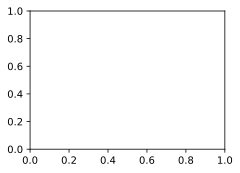

In [114]:
image_net_train_dataset = ImageNetMiniDataset(labels_path,image_path,resize=(224,224),transform=transform)
image_net_test_dataset = ImageNetMiniDataset(labels_path,image_path,resize=(224,224),train=False, transform=transform)
train_iter = LazyDataLoader(image_net_train_dataset, batch_size=1000, shuffle=True, num_workers=multiprocessing.cpu_count())
test_iter = LazyDataLoader(image_net_test_dataset, batch_size=100, num_workers=multiprocessing.cpu_count())

lr, num_epochs = 0.9, 10
train(net, train_iter, test_iter, num_epochs, lr, try_gpu())

In [53]:
# torch.save(net.state_dict(),'parameters.pt')
# model_dict = torch.load('parameters.pt')
# net.load_state_dict(model_dict)

261, n04579145, whiskey jug
, 0.746493935585022
316, n03485407, hand-held computer, hand-held microcomputer
, 0.7406399250030518
120, n02916936, bulletproof vest
, 0.5654940009117126
9, n03623198, knee pad
, 0.554460883140564
150, n02102480, Sussex spaniel
, 0.5396345853805542


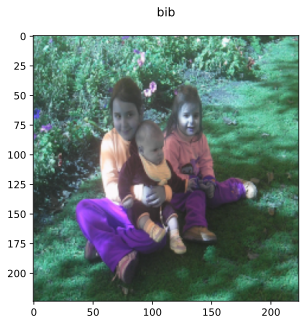

261, n04579145, whiskey jug
, 0.8045986294746399
316, n03485407, hand-held computer, hand-held microcomputer
, 0.8019571304321289
120, n02916936, bulletproof vest
, 0.6041427254676819
9, n03623198, knee pad
, 0.5982462167739868
150, n02102480, Sussex spaniel
, 0.5717818737030029


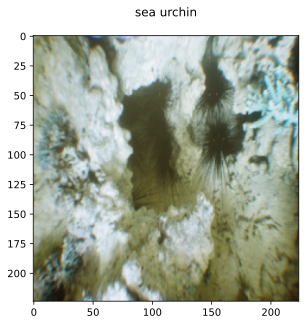

261, n04579145, whiskey jug
, 0.7333868741989136
316, n03485407, hand-held computer, hand-held microcomputer
, 0.7291883230209351
120, n02916936, bulletproof vest
, 0.5661380290985107
9, n03623198, knee pad
, 0.5481812953948975
150, n02102480, Sussex spaniel
, 0.5382776856422424


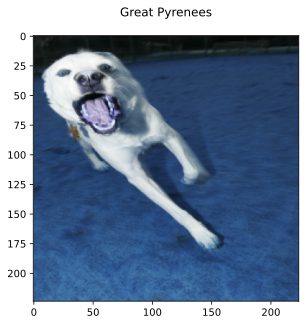

261, n04579145, whiskey jug
, 0.7434631586074829
316, n03485407, hand-held computer, hand-held microcomputer
, 0.7385810613632202
120, n02916936, bulletproof vest
, 0.5651330947875977
9, n03623198, knee pad
, 0.5564365386962891
150, n02102480, Sussex spaniel
, 0.5379465222358704


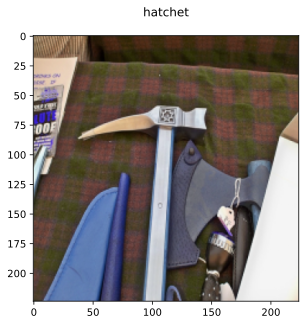

261, n04579145, whiskey jug
, 0.7591272592544556
316, n03485407, hand-held computer, hand-held microcomputer
, 0.7583032250404358
120, n02916936, bulletproof vest
, 0.5724372863769531
9, n03623198, knee pad
, 0.5675637722015381
150, n02102480, Sussex spaniel
, 0.5462907552719116


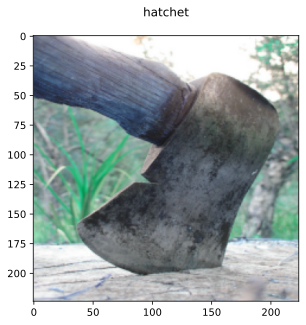

261, n04579145, whiskey jug
, 0.7624906301498413
316, n03485407, hand-held computer, hand-held microcomputer
, 0.7579241394996643
120, n02916936, bulletproof vest
, 0.5748544335365295
9, n03623198, knee pad
, 0.5669875144958496
150, n02102480, Sussex spaniel
, 0.5482271909713745


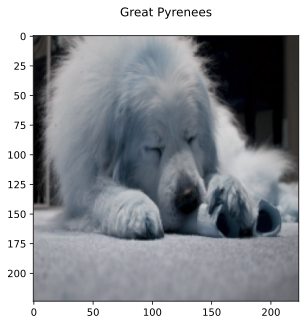

261, n04579145, whiskey jug
, 0.746493935585022
316, n03485407, hand-held computer, hand-held microcomputer
, 0.7406399250030518
120, n02916936, bulletproof vest
, 0.5654940009117126
9, n03623198, knee pad
, 0.554460883140564
150, n02102480, Sussex spaniel
, 0.5396345853805542


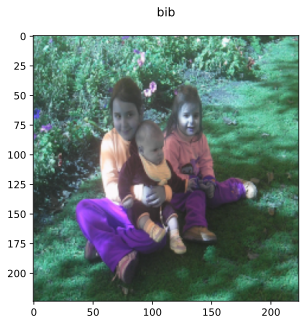

261, n04579145, whiskey jug
, 0.722813069820404
316, n03485407, hand-held computer, hand-held microcomputer
, 0.7183917760848999
120, n02916936, bulletproof vest
, 0.5481160879135132
9, n03623198, knee pad
, 0.5398274064064026
150, n02102480, Sussex spaniel
, 0.5233157277107239


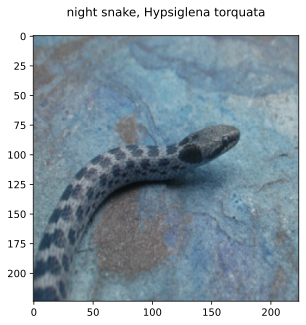

261, n04579145, whiskey jug
, 0.7625241279602051
316, n03485407, hand-held computer, hand-held microcomputer
, 0.7490244507789612
120, n02916936, bulletproof vest
, 0.5745484828948975
9, n03623198, knee pad
, 0.5637319684028625
150, n02102480, Sussex spaniel
, 0.549284815788269


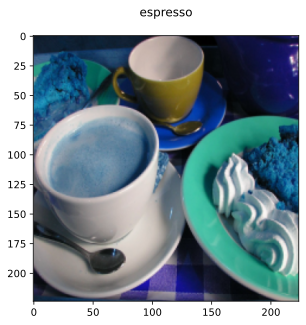

261, n04579145, whiskey jug
, 0.7852590680122375
316, n03485407, hand-held computer, hand-held microcomputer
, 0.7800942659378052
120, n02916936, bulletproof vest
, 0.5867863893508911
9, n03623198, knee pad
, 0.5852468609809875
150, n02102480, Sussex spaniel
, 0.559988796710968


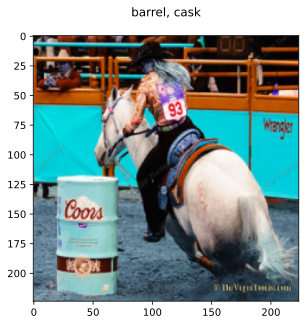

In [98]:
net.eval()
for i in range(10):
    index = random.randint(0,len(test_iter))
    input = torch.unsqueeze(image_net_test_dataset[index][0],0)
    # print(torch.topk(net(input),5).values.tolist()[0])
    # or i in torch.topk(net(input),5):
    # n04579145,n03485407,n02916936,n03623198,n02102480
    # print(train_iter.label_map)
    reverse_dict = {v : k for k,v in train_iter.label_map.items()}
    # print(reverse_dict)
    for i,prob in zip(torch.topk(net(input),5).indices.tolist()[0],torch.topk(net(input),5).values.tolist()[0]):
        key = reverse_dict[i]
        print(f'{i}, {key}, {image_net_train_dataset.img_labels[key]}, {prob}')
    plt.imshow(image_net_test_dataset[index][0].permute(1,2,0))
    plt.title(image_net_train_dataset.img_labels[image_net_test_dataset[index][1]])
    plt.show()